$$\require{mhchem}$$       

# Notes

## Github, docker review

## De-bugging

In [45]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

def dydx(y, t):
    return y

def objective(tmax):
    xspan = np.linspace(0, tmax)
    y0 = 1
    sol = odeint(dydx, y0, xspan)
    return sol[-1]-2

sol = fsolve(objective,0.4)

print('The integration reaches 2 at %1.3f'%sol)

The integration reaches 2 at 0.693



# Mole balance in a plug flow reactor



-   In the plug flow reactor, reactants enter the front of the reactor and disappear as they flow through the reactor

![img](./images/pfr-schematic.png)

-   We assume our differential element is well-mixed
-   The mole balance on the differential element leads to

$ \frac{dN_A}{dt} = F_A |_V - F_A |_{V + \Delta V} + \Delta V r_A $

-   At steady state, in the limit of $\Delta V \rightarrow 0$ we get:

$ \frac{dF_A}{dV} = r_A $

-   This is an ordinary differential equation (but it varies in space, not time), and to solve it we need an initial condition on the molar flow at $V=0$.




## A worked PFR example



-   Given a 100 L reactor with $A$ flowing in at a concentration of 3 mol/L and a rate of 10 L/min
-   The reaction $\ce{A-> B}$ occurs at a rate law of $r = k C_A$ with $k = 0.23$ 1/min
-   What is the exit concentration of $A$?

-   We have $\frac{dF_A}{dV} = r_A $
-   We have $r_A = -r$ (stoichiometry)
-   $F_A(V=0) = C_{A0} v_0$



In [1]:
from scipy.integrate import odeint

Ca0 = 3.0  # mol / L
v0 = 10.0  # volumetric flowrate L/min
k = 0.23   # rate constant 1/min

def ode(Fa, V):
    Ca = Fa / v0
    return -k * Ca

Vspan = [0, 100] # reactor volume

sol = odeint(ode, Ca0 * v0, Vspan)
Fa_exit = sol[-1, 0] # last row, column 0

print('Exit concentration = {0:1.4f} mol/L'.format(Fa_exit / v0))

Exit concentration = 0.3008 mol/L


In [2]:
sol

array([[30.       ],
       [ 3.0077653]])

-   Our solution only has two points in it: 0 and 100L
    -   We cannot visualize the concentration profile




## A harder PFR example



-   The reaction $\ce{A->B}$ occurs at a rate law of $r = k C_A$ with $k = 0.23$ 1/min
-   If  $A$ is flowing in at a concentration of 3 mol/L and a rate of 10 L/min
-   How large should the reactor be to reduce the concentration of $A$ to 0.3 mol/L?

There are many ways to approach this.

-   You could integrate $\frac{dF_A}{dV} = r_A$ and graphically determine where the solution is.
-   You could setup a numerical approach to solving the equation

-   First we graph the solution. the code is almost the same as before, but we integrate over more points and a larger range to get a smooth curve.



In [3]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

Ca0 = 3.0 # mol / L
v0 = 10.0 # L / min
k = 0.23  # 1/min

def ode(Fa, V):
    Ca = Fa / v0
    return -k * Ca

Vspan = np.linspace(0, 200) # volumes to integrate over

sol = odeint(ode, Ca0 * v0, Vspan)

plt.plot(Vspan, sol)
plt.xlabel('Volume (L)')
plt.ylabel('$F_A$ (mol/min)')
plt.show()

<Figure size 640x480 with 1 Axes>

-   at $C_A = 0.3$ mol/L, $F_A = 3$ mol/min.
-   We know the answer from before: It is about 100 L.
-   It is hard to be very accurate this way, although interactive graphics help



## Numerical solution



-   To numerically solve this we must solve a function $f(V) = 0$.
-   Here is one approach
-   Starting from $\frac{dF_A}{dV} = -k F_A/\nu$ we derive:

\begin{align}
f(V) = \int_{F_{A0}}^{F_A} \frac{dF_A}{F_A} - \int_{V=0}^{V} \frac{-k}{\nu}dV
\end{align}

where everything is known but $V$. We use numerical quadrature to evaluate the integrals.

[scipy.integrate.quad](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html)



In [4]:
from scipy.integrate import quad
from scipy.optimize import fsolve

k = 0.23        # 1/min
nu = 10         # L/min
Ca0 = 3.0       # mol / L
Fa0 = Ca0 * nu
Fa = 0.30 * nu

def integrand1(Fa):
    return 1.0 / Fa

def integrand2(V):
    return -k / nu

def func(V):
    I1, e1 = quad(integrand1, Fa0, Fa)
    I2, e2 = quad(integrand2, 0, V)
    return I1 - I2

guess = 120 # Liters
sol = fsolve(func, guess)
print('Volume = {0:1.2f}'.format(float(sol)))

Volume = 100.11


-   This also leaves something to be desired in complexity
-   Many opportunities for mistakes in the derivation
-   Requires sophisticated thinking about the problem
-   Other approaches require similar or more sophistication!




## Using events to stop integration



-   An alternative to the methods above is to use an ODE solver that is aware of events to stop the integration where you want it.

-   `pycse` provides a function like this called `odelay`. [pycse.odelay](https://www.google.com/#safe=off&q=pycse.odelay)

-   You define an event function that equals zero at the event. You specify if the event is terminal, and whether to the zero must be approached from above or below, or if all zeros count.

-   Here is an example.



Solution is at [array([100.16198166])] L


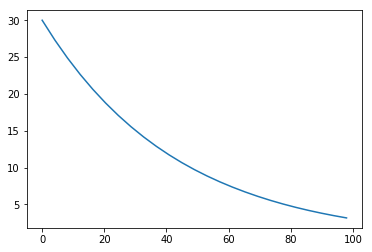

In [29]:
import numpy as np
from scipy.integrate import solve_ivp

# from pycse import odelay

Ca0 = 3.0  # mol / L
v0 = 10.0  # L / min
k = 0.23   # 1 / min

Fa_Exit = 0.3 * v0

def ode(V, Fa):
    Ca = Fa / v0
    return -k * Ca

def event1(V, Fa):
    value = Fa - Fa_Exit
    return value

event1.terminal = True
event1.direction = 0


Vspan = [0, 200] # L

sol = solve_ivp(ode, Vspan, np.array([Ca0 * v0]), events=event1, t_eval = np.linspace(0,200))
#sol = solve_ivp(ode, Vspan, np.array([Ca0 * v0]))

print('Solution is at {0} L'.format(sol.t_events))
import matplotlib.pyplot as plt

plt.plot(sol.t, sol.y[0,:])

plt.show()

In [ ]:
import numpy as np
from pycse import odelay

Ca0 = 3.0  # mol / L
v0 = 10.0  # L / min
k = 0.23   # 1 / min

Fa_Exit = 0.3 * v0

def ode(Fa, V):
    Ca = Fa / v0
    return -k * Ca

def event1(Fa, V):
    isterminal = True
    direction = 0
    value = Fa - Fa_Exit
    return value, isterminal, direction

Vspan = np.linspace(0, 200) # L

V, F, TE, YE, IE = odelay(ode, Ca0 * v0, Vspan, events=[event1])

print('Solution is at {0} L'.format(V[-1]))
import matplotlib.pyplot as plt

plt.plot(V, F)

plt.show()

-   As you can see, there are many ways to solve this problem
-   It is *not* necessary to know every single way to do it, but knowing multiple ways increases your ability to solve other problems in the future
-   And provides ways to check your solution by other methods.




## Solution by interpolation



-   Solve the problem on a grid
-   Create interpolation function for the solution to approximate solutions between grid points.  [scipy.interpolate.interp1d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html)
-   Use fsolve to find the solution



In [ ]:
import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import interp1d

Ca0 = 3.0  # mol / L
v0 = 10.0  # L / min
k = 0.23   # 1 / min

def ode(Fa, V):
    'dFa/dV = ra'
    Ca = Fa / v0
    r = k * Ca
    ra = -r
    return ra

Vspan = np.linspace(0, 200,5) # L

sol = odeint(ode, Ca0 * v0, Vspan)

Ca_exit = 0.3 # mol / L
Fa_exit = Ca_exit * v0

# Note that here we cannot mix 1d and 2d arrays. We must extract a 1d
# array from the solution. We do that with sol[:, 0] which means take
# all rows in column 0.
interp_func = interp1d(Vspan, sol[:, 0], 'cubic')

def objective(V):
    'equal to zero when F(V) = Fa_exit'
    return interp_func(V) - Fa_exit

from scipy.optimize import fsolve
V_sol = fsolve(objective, 100)
print('Solution is at {0} L'.format(float(V_sol)))

-   Note that you may be limited by the accuracy of your interpolation here. Solving the ODE with a fine mesh of points will increase the accuracy of the solution. Or using more accurate interpolations, e.g. splines, can also increase the accuracy.



In [ ]:
print(interp_func)

# Mole balances with changing number of moles

-   The reason it is important to know whether the total number of moles is changing in a reactor is because we define the concentration of a species in a flowing system as

$C_j = \frac{F_j}{\nu}$

where $\nu$ is the total volumetric flowrate, and we need these concentrations to evaluate the rate laws.

-   For reactions with no change in total moles, no pressure drops, and isothermal conditions, &nu; is a constant.

-   In all other cases, &nu; changes, and we have to compute &nu; to compute the concentrations for use in the rate laws.

-   We know at the entrance of the reactor that

$P_0 \nu_0 = F_{T0} R T_0 Z_0$

-   Here we have the initial pressure, volumetric flowrate, temperature and compressibility factor. At some later point in the reactor or in time, we also have:

$P \nu = F_T R T Z$

-   Now, even if we are isothermal, so that $T = T_0$; isobaric, so that $P = P_0$; and there is no change in compressibility, i.e. $Z = Z_0$, if the total molar flow rate has changed, there will be a change in the volumetric flow.

-   The ratio of these two equations leads to this expression for the volumetric flow rate in a reactor where the total number of moles is changing:

$\nu = \nu_0 \frac{F_T}{F_{T0}} \frac{P0}{P} \frac{T}{T_0} \frac{Z}{Z_0} $

-   Here, the total molar flow is simply the sum of the molar flows of each species (including inert species) in the reactor, $F_T = \sum_{i=0}^N F_j$.

-   That means we now need to calculate the molar flow of each species, which in general means we will have a species mole balance for each species. For single reactions, it is often possible to relate these molar flows by stoichiometry.

-   Consider this reaction, e.g. ethane cracking to ethylene and hydrogen.

$\ce{A -> B + C}$

-   As the reaction proceeds, we convert one mole of reactants to two moles of products.

-   We want to design a plug flow reactor to consume 80% of the ethane that enters the reactor. It is given that $-r_A = k C_A$ with $k=0.072$ 1/s at 1000K.

-   Let the initial molar flowrate be 0.425 mol / s of pure A into the reactor at a total pressure of 6 atm. The initial concentration of A is $C_{A0} = P_{A0} / (R T)$. From this, we calculate the initial volumetric flowrate: $\nu_0 = F_{A0} / C_{A0}$

-   first we use the quantities package to do some unit conversions to get consistent SI units



In [ ]:
import quantities as u

PA0 = 6 * u.atm
T = 1000 * u.K
R = 8.314 * u.J / u.mol / u.K

CA0 = PA0 / ( R * T)

# note the use of {{}}. This is to get {} in the output.
# If we used {A0} we would get an error, because of the formatting.
print('C_{{A0}} = {0}'.format(CA0))
print('C_{{A0}} (simplified) = {0}'.format(CA0.simplified))

FA0 = 0.425 * u.mol / u.s
v0 = FA0 / CA0

# note the double \\. That is because \n is a carriage return
# we have to use a \ to escape the \, so that we see \ in the
# printed output. We want that so it is in LaTeX format.
print('$\\nu_{{0}} = {0}$'.format(v0.simplified))

-   If we assume there is no pressure drop, and that 80% of A has reacted at the exit, with pure A at the entrance, then we know from stoichiometry that there will be this total molar flow at the exit:

$0.20 F_{A0} + 0.8 F_{A0} + 0.8 F_{A0}$

Thus, we can calculate the exit concentration as $ 0.2 F_{A0} / \nu_{exit}$:



In [ ]:
import quantities as u
FA0 = 0.425 * u.mol / u.s
PA0 = 6 * u.atm
T = 1000 * u.K
R = 8.314 * u.J / u.mol / u.K

CA0 = PA0 / ( R * T)
v0 = FA0 / CA0

# Total molar exit flow
F_exit = 0.2 * FA0 + 0.8 * FA0 + 0.8 * FA0

v = v0 * F_exit / FA0
print('Entrance volumetric flowrate is {0}.'.format(v0.simplified))
print('Exit volumetric flowrate is {0}.'.format(v.simplified))

CA_exit = 0.2 * FA0 / v

# Note the triple quoted, multiline string.
print('''Exit concentration of A is {0}

which is not 0.2 * CA0 ({1})'''.format(CA_exit.simplified,
                                         (0.2 * CA0).simplified))

-   You can see just by this algebra that the concentration changes because of the chemical reaction that consumes A, but also because the number of moles is changing, and the volumetric flowrate is increasing.

-   Since the volumetric flow is changing, the concentration changes

-   We have to account for that in our mole balances. The normal mole balance for a plug flow reactor looks like:

$\frac{dF_A}{dV} = r_A $. Here, it is convenient to invert the equation:

$\frac{dV}{dF_A} = \frac{1}{r_A} $

because then we can integrate over the molar flow to directly compute the volume.

-   this only works for this simple ODE.
-   We compute the molar flows of B and C using the reaction extent: $F_j = F_{j0} + \xi \alpha_j$.

-   Note we are not using the quantities package here. But we use the results from above to get the units consistent in SI.



In [ ]:
import numpy as np
from scipy.integrate import odeint

Fa0 = 0.425             # mol / s
Fb0 = 0
Fc0 = 0
Fa_exit = 0.2 * Fa0

# we previously calculated this number
v0 = 0.0058120733613    # m**3 / s
k = 0.072               # 1 / s

def dVdFa(V, Fa):
    xi = (Fa - Fa0) / (-1) # compute reaction extent
    Fb = Fb0 + xi * 1
    Fc = Fc0 + xi * 1
    Ft = Fa + Fb + Fc   # total molar flow
    v = v0  * Ft / Fa0   # volumetric flow

    Ca = Fa / v
    ra = -k * Ca
    return 1.0 / ra

Fspan = np.linspace(Fa0, Fa_exit)

V0 = 0
sol = odeint(dVdFa, V0, Fspan)

print('At a volume of {0:1.3f} m^3 we achieve 80% conversion of A'.format(sol[-1][0]))

import matplotlib.pyplot as plt
plt.plot(Fspan, sol)
plt.xlabel('F$_A$ (mol/s)')
plt.ylabel('Volume (m$^3$)')
plt.show()

-   An alternative approach, and one that is needed for multiple reactions, is to use a mole balance for each species:

\begin{align}
\frac{dF_A}{dV} = r_A \\
\frac{dF_B}{dV} = r_B \\
\frac{dF_C}{dV} = r_C
\end{align}

-   and to relate the rates of each species reaction rate to each other via stoichimetry:

$ r = \frac{r_A}{-1} = \frac{r_B}{1} = \frac{r_C}{1} $

-   Here we cannot invert the ODE, because we have coupled odes.



At a volume of 0.195 m^3 we achieve 80% conversion of A


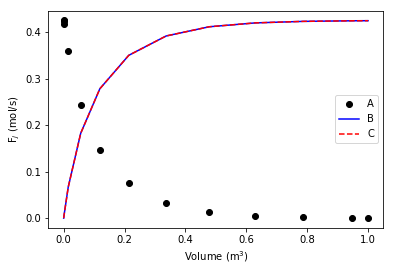

In [43]:
import numpy as np
from pycse import odelay

Fa0 = 0.425             # mol / s
Fa_exit = 0.2 * Fa0

v0 = 0.0058120733613    # m^3 / s
k = 0.072               # 1 / s

Ft0 = Fa0

def dFdV(V, F):

    Fa, Fb, Fc = F    # we only need Fa for the rate law
    Ft = sum(F)       # total flow rate
    v = v0 * Ft / Ft0

    Ca = Fa / v
    ra = - k * Ca
    rb = -ra
    rc = -ra

    dFadV = ra
    dFbdV = rb
    dFcdV = rc

    return [dFadV, dFbdV, dFcdV]

def event(V, F):
    Fa, Fb, Fc = F
    value = Fa - 0.2 * Fa0
    return value

event.isterminal = True
event.direction = 0

Vspan = np.linspace(0, 1)  # m**3
Vspan = [0,1]
# Initial conditions, one for each ODE
F0 = [Fa0, 0, 0]

sol = solve_ivp(dFdV, Vspan, F0, events=event)

print('At a volume of {0:1.3f} m^3 we achieve 80% conversion of A'.format(sol.t_events[0][0]))

import matplotlib.pyplot as plt
Fa = sol.y[0,:]
Fb = sol.y[1,:]
Fc = sol.y[2, :]

plt.plot(sol.t, Fa, 'ko',
         sol.t, Fb, 'b',
         sol.t, Fc, 'r--')

plt.xlabel('Volume (m$^3$)')
plt.ylabel('F$_j$ (mol/s)')

plt.legend(['A', 'B', 'C'])
plt.show()

-   This approach is more involved, but when there are multiple reactions, and net rates of reaction must be considered, this is the only way to proceed with reactor design.


## Summary

-   It is important to keep track of when the number of moles in a reaction change because we define the concentration of a species as

$C_j = F_j / \nu $

-   and &nu; depends on the total number of moles in the system.

$\nu = \nu_0 \frac{F_T}{F_{T0}} \frac{P0}{P} \frac{T}{T_0} \frac{Z}{Z_0} $

-   We will see in the next section that pressure drops affect reactor design because of the change it causes in volumetric flow also.



# Mole balances with pressure drops

-   We have previously seen that we must account for changing volumetric flowrates in reactor design because the concentrations of species used in computing reaction rates are dependent on the volumetric flowrate.

-   This can be important even when the total molar flow is constant, if there is a pressure drop in the reactor, i.e. if the pressure at the entrance is not the same as the pressure at the exit of the reactor:

$\nu = \nu_0 \frac{F_T}{F_{T0}} \frac{P_0}{P} \frac{T}{T_0} \frac{Z}{Z_0} $

-   Since the pressure drops through a reactor, if nothing else changes, the volumetric flow will increase (this is a consequence of conservation of mass). The consequence of this is the following:

$C_A = \frac{F_A}{\nu} = \frac{F_A}{\nu_0}\frac{F_{T0}}{F_{T}} \frac{P}{P_0} $

-   This is especially important for packed bed reactors, which are often filled with catalyst beads that can impede the flow.

-   Since we apply this specifically to a packed bed reactor, it is convenient to work in terms of catalyst weight, rather than reactor volume.

-   The two quantities are related by $W = \rho_b V = \rho_c (1 - \phi) V$ where $W$ is the weight, &rho;\_b is the bulk catalyst density, &rho;\_c is the density of solid catalyst, and &phi; is the porosity of the catalyst.

-   We know how to develop mole balances for $F_A$, but these will lead to equations of the form $\frac{dF_j}{dW} = f(F, P)$, which has an additional variable $P$ in it. Now  we need to have a quantitative expression for the pressure at some point in a reactor, as a function of the molar flows of each species.

-   The pressure drop through a packed bed can be modeled with the Ergun equation. This is one of the more common approaches to considering pressure drops.

-   The most important result is that

$\frac{dP}{dW} = -\frac{\beta_0}{A_c (1 - \phi) \rho_c}\frac{P_0}{P} \frac{T}{T_0} \frac{F_T}{F_{T0}} $

where:

$\beta_0 = \frac{G (1 - \phi)}{\rho_0 g_c D_p \phi^3}\left [ \frac{150 (1 - \phi) \mu}{D_p} + 1.75 G \right] $

-   &beta;\_0 is a constant that depends only on the properties of the packed bed, and the entrance gas conditions:

<table border="2" cellspacing="0" cellpadding="6" rules="groups" frame="hsides">


<colgroup>
<col  class="org-left" />

<col  class="org-left" />
</colgroup>
<tbody>
<tr>
<td class="org-left">A\_c</td>
<td class="org-left">bed cross-sectional area</td>
</tr>


<tr>
<td class="org-left">&rho;\_c</td>
<td class="org-left">solid catalyst density</td>
</tr>


<tr>
<td class="org-left">&phi;</td>
<td class="org-left">catalyst porosity</td>
</tr>


<tr>
<td class="org-left">&mu;</td>
<td class="org-left">gas viscosity</td>
</tr>


<tr>
<td class="org-left">G</td>
<td class="org-left">superficial mass velocity (&rho; u)</td>
</tr>


<tr>
<td class="org-left">u</td>
<td class="org-left">superficial velocity (volumetric flow / A\_c)</td>
</tr>


<tr>
<td class="org-left">D\_p</td>
<td class="org-left">catalyst bead diameter</td>
</tr>


<tr>
<td class="org-left">g\_c</td>
<td class="org-left">32.174 lb\_m ft/s^2/lb\_f     (in metric g\_c=1)</td>
</tr>


<tr>
<td class="org-left">&rho;\_0</td>
<td class="org-left">inlet gas density</td>
</tr>
</tbody>
</table>

-   Clearly, we need additional data, but the data are all constants. In fact, it is customary to lump additional constants, and to define:

$\alpha = \frac{2 \beta_0}{A_c \rho_c (1 - \phi) P_0} $ and to define $y = P / P_0$ so that we can reexpress the differential equation as:

$ \frac{dy}{dW} = -\frac{\alpha}{2 y}\frac{T}{T_0} \frac{F_T}{F_{T0}} $   (this is the important equation to remember)

-   This equation has an analytical solution when there is no change in the total number of moles. From here you can see that y will decrease in an isothermal, isomolar reaction due to the negative sign.

-   This equation depends on $F_T$, so it is coupled to the mole balances. So, we will typically have equations such as:

\begin{align}
\frac{dF_A}{dW} = r_A \\
\frac{dF_B}{dW} = r_B \\
\vdots \\
\frac{dy}{dW} = -\frac{\alpha}{2 y}\frac{T}{T_0} \frac{F_T}{F_{T0}}
\end{align}

which must be numerically integrated with appropriate initial conditions.



## A worked example with a pressure drop and inerts

-   We consider the partial oxidation of ethylene to ethylene oxide:

$\ce{C_{2}H_4 + 1/2O_2 -> C_{2}H_{4}O}$

-   Oxygen is fed in a stoichiometric amount in the form of air.

-   The rate law is given as $-r_A = k P_A^{1/3} P_B^{2/3}$.
    -   $k = 0.0141$ lb-mol / (atm \* lb\_m cat \* h)

-   A is fed at a rate of $F_{A0}$ = 1.08 lbmol / h
-   B is fed at a rate of $0.5  F_{A0}$
-   $F_{N_2} = F_B  0.8 / 0.2$

-   The feed pressure is 10 atm.

-   &alpha; for the conditions and bed are provided as 0.0166 1 / (lb\_m cat).

-   Let us estimate the catalyst weight required to achieve 60% conversion of A.

-   We need a mole balance for each species so we can compute the total molar flow rate at any point.
    -   We use the total molar flowrate to compute the total pressure
    -   We use the mole fraction of each species to compute the species partial pressure for use in the rate law.
    -   We use reaction stoichiometry to relate the species rates

-   We need a differential equation on the change in pressure



In [ ]:
import numpy as np
from scipy.integrate import odeint

Fa0 = 1.08 # lbmol / h
Fb0 = 0.5 * Fa0
FI0 = Fb0 * 0.8 / 0.2  # flow rate of N2
Fc0 = 0.0

Ft0 = Fa0 + Fb0 + FI0 + Fc0
P0 = 10 # atm

alpha = 0.0166 # 1 / lb_m cat
k = 0.0141 # lb-mol / (atm * lb_m cat * h)

def ode(F, W):
    Fa, Fb, Fc, y = F  # unpack the variables
    P = y * P0

    Ft = Fa + Fb + Fc + FI0 # do not forget the inerts!

    Pa = Fa / Ft * P
    Pb = Fb / Ft * P

    # the stoichiometry
    ra = -k * Pa**(1.0/3.0) * Pb**(2.0 / 3.0)
    rb = 0.5 * ra
    rc = -ra

    # define the 4 coupled ODES
    dFadW = ra
    dFbdW = rb
    dFcdW = rc
    dydW = -alpha /(2 * y) * Ft / Ft0

    return [dFadW, dFbdW, dFcdW, dydW]

# initial conditions
y0 = 1.0 # P0/P0
F0 = [Fa0, Fb0, Fc0, y0]

Wspan = np.linspace(0, 50) # lb_m cat

sol = odeint(ode, F0, Wspan)

import matplotlib.pyplot as plt

Fa = sol[:, 0]
Fb = sol[:, 1]
Fc = sol[:, 2]
y = sol[:, 3]



plt.subplot(1, 2, 1) # subplot with two columns in one row
plt.plot(Wspan, sol[:, 0:3]) # plot columns 0, 1, 2

plt.plot(Wspan, Fa, Wspan, Fb, Wspan, Fc)

plt.legend(['A', 'B', 'C'], loc='lower center')
plt.xlabel('Catalyst weight ($lb_m$)')
plt.ylabel('Molar flow (mol/min)')

plt.subplot(1, 2, 2)
plt.plot(Wspan, sol[:, 3], 'k--') # plot column 3
plt.xlabel('Catalyst weight ($lb_m$)')
plt.ylabel('$P/P_0$')
plt.legend(['$P/P_0$'],loc='upper right')

plt.tight_layout()
plt.show()

Fa, Fb, Fc, y = sol.T
X = (Fa0 - Fa[-1])/ Fa0

print(X)

-   You can see more than 50% pressure drop over the length of the bed

-   Set &alpha; to 0 to see the effect of the pressure drop. Does conversion increase or decrease?



In [ ]:
import numpy as np

A = np.array([[0, 1], [1, 2], [3, 4]])

print(A[:, 0])

a, b, c = A

print(a)
print(b)

print(A.T)
d, e = A.T
print(d)


Alist = [[0, 1], [1, 2], [3, 4]]
print(Alist)
print(np.transpose(Alist))

In [ ]:
import numpy as np

print(np.hstack([[0, 1], [2, 3]]))
print(np.vstack([[0, 1], [2, 3]]))